In [145]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

df = pd.read_csv('Users/sage/Desktop/Kitchen_encoded.csv',parse_dates=['DateOfCancel','DateOfService'])



In [146]:
###implementing the savgol smoothing
df = df.sort_values(['Site','MenuBase','DateOfService']).reset_index(drop=True)

window=7
poly = 2

def smooth_def_net(group):
    val = group['net_qty'].to_numpy()
    n = val.size
    if n<window:
        return group['net_qty']
    w = min(window, n if n % 2==1 else n-1)
    return pd.Series(savgol_filter(val,w,poly),index=group.index)

df['net_qty_sg'] = (df.groupby(['Site','MenuBase'],group_keys=False).apply(smooth_def_net))

print(df[['Site','MenuBase','net_qty','net_qty_sg']].tail(10))


         Site  MenuBase  net_qty  net_qty_sg
5671156   3.0      23.0        1         1.0
5671157   3.0      23.0        1         1.0
5671158   3.0      23.0        1         1.0
5671159   3.0      23.0        1         1.0
5671160   3.0      23.0        1         1.0
5671161   3.0      23.0        1         1.0
5671162   3.0      23.0        1         1.0
5671163   3.0      23.0        1         1.0
5671164   3.0      23.0        1         1.0
5671165   3.0      23.0        1         1.0


/var/folders/b9/jc1xw4dx0mvfybfcqtc_3xm40000gn/T/ipykernel_27418/2198962321.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['net_qty_sg'] = (df.groupby(['Site','MenuBase'],group_keys=False).apply(smooth_def_net))


In [147]:
####Smoothing feature using MA
df['net_qty_roll'] = (df.groupby(['Site','MenuBase'])['net_qty'].transform(lambda x: x.rolling(window=window,min_periods = 1).mean()))


In [148]:
#### Smoothing feature using SG for subsidy_pct(check code and drop or remove inf and nan values from subsidy_pct)

def sub_smooth_sg(group):
    val = group['subsidy_pct'].to_numpy()
    n = val.size
    if n<window:
        return group['subsidy_pct']
    w = min(window,n if n %2 ==1 else n-1)
    return pd.Series(savgol_filter(val,w,poly),index=group.index)

df['subsidy_pct_sg'] = (df.groupby(['Site','MenuBase'],group_keys=False).apply(sub_smooth_sg))

print(df[['net_qty','net_qty_roll','subsidy_pct','subsidy_pct_sg']])

         net_qty  net_qty_roll  subsidy_pct  subsidy_pct_sg
0              1           1.0          inf             NaN
1              1           1.0          0.0             NaN
2              1           1.0          0.0             NaN
3              1           1.0          0.0             NaN
4              1           1.0          0.0             inf
...          ...           ...          ...             ...
5671161        1           1.0          inf             NaN
5671162        1           1.0          inf             NaN
5671163        1           1.0          inf             NaN
5671164        1           1.0          0.0             NaN
5671165        1           1.0          inf             NaN

[5671166 rows x 4 columns]


/var/folders/b9/jc1xw4dx0mvfybfcqtc_3xm40000gn/T/ipykernel_27418/592601911.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['subsidy_pct_sg'] = (df.groupby(['Site','MenuBase'],group_keys=False).apply(sub_smooth_sg))


In [20]:
df['cancel_timing'].unique()

array([3., 0., 4., 1., 2.])

In [24]:
print('The net_qty summary')
print(df['net_qty'].describe())
print('the bins \n ' )
print(df['cancel_timing'].value_counts(normalize=True).sort_index())


The net_qty summary
count    5.671166e+06
mean     9.990490e-01
std      4.092831e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.200000e+02
Name: net_qty, dtype: float64
the bins 
 
cancel_timing
0.0    0.000912
1.0    0.000174
2.0    0.008289
3.0    0.988202
4.0    0.002422
Name: proportion, dtype: float64


<Figure size 1000x600 with 0 Axes>

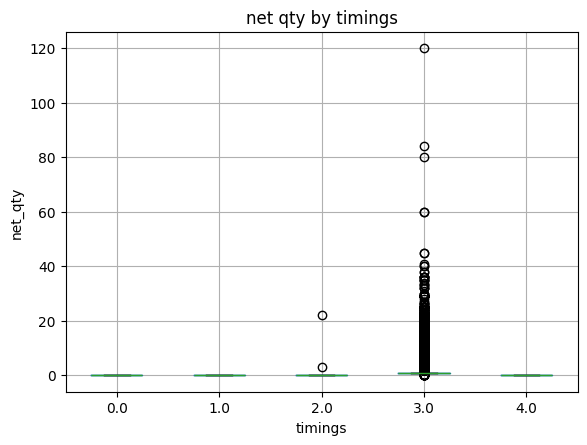

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df.boxplot(column='net_qty',by='cancel_timing')
plt.title('net qty by timings')
plt.xlabel('timings')
plt.ylabel('net_qty')
plt.suptitle('')
plt.show()

In [ ]:
#### do the vif check
from statsmodels.stats.outliers_influence import variance_inflation_factor
num_cols = df.select_dtypes(include=[np.number]).columns.to_list()

drop_col = ['DateOfOrder', 'DateOfService','days_to_cancel','net_qty_sg','net_qty_roll','CanceledQty','OrderId', 'TransactionId','cancel_timing','BookingNr','DateOfCancel','net_qty']

vif_col = [c for c in num_cols if c not in drop_col]

vif_dat = df[vif_col].copy()
vif_dat.replace([np.inf,-np.inf],np.nan,inplace=True)
vif_dat = vif_dat.dropna()
vif_scores = [variance_inflation_factor(vif_dat,i)
              for i in range(vif_dat.shape[1])
              ]

vif_table = (pd.DataFrame({'feature':vif_col,'VIF':vif_scores}).sort_values('VIF',ascending=False).reset_index(drop=True))
print('VIF values')
display(vif_table)

hg_vif = vif_table.loc[vif_table['VIF']>10,'faeture'].to_list()
print('the high vif columns dropped')
df_without_vif = vif_dat.drop(columns=hg_vif)
print(df_without_vif.columns)

VIF values


,faeture,VIF
0,evening,1.192302e+10
1,morning,4.528730e+08
2,afternoon,2.467988e+08
3,day_of_year,2.223740e+04
4,month,2.206734e+04
5,day_of_month,1.161921e+02
6,quarter,2.118267e+01
7,MenuSubsidy,1.313001e+01
8,subsidy_pct,1.279703e+01
9,order_hour,5.616081e+00


(5671166, 35)

In [150]:
###### vif after incorporating the weather varibales
#### do the vif check
from statsmodels.stats.outliers_influence import variance_inflation_factor
num_cols = df_weather.select_dtypes(include=[np.number]).columns.to_list()

drop_col = ['DateOfOrder', 'DateOfService','days_to_cancel','net_qty_sg','net_qty_roll','CanceledQty','OrderId', 'TransactionId','cancel_timing','BookingNr','DateOfCancel','net_qty']

vif_col_1 = [c for c in num_cols if c not in drop_col]

vif_dat_1 = df_weather[vif_col_1].copy()
vif_dat_1.replace([np.inf,-np.inf],np.nan,inplace=True)
vif_dat_1 = vif_dat_1.dropna()
vif_scores_1 = [variance_inflation_factor(vif_dat_1,i)
              for i in range(vif_dat_1.shape[1])
              ]

vif_table_1 = (pd.DataFrame({'feature':vif_col_1,'VIF':vif_scores_1}).sort_values('VIF',ascending=False).reset_index(drop=True))
print('VIF values')
display(vif_table_1)

hg_vif_1 = vif_table_1.loc[vif_table_1['VIF']>10,'feature'].to_list()
print('the high vif columns dropped')
df_without_vif_1 = vif_dat_1.drop(columns=hg_vif_1)
print(df_without_vif_1.columns)

VIF values


,feature,VIF
0,hist_cancel_rate,2.843646
1,SchoolID,2.667064
2,Site,2.164007
3,MenuPrice,2.143505
4,subsidy_pct_sg,1.794462
5,rain_flag,1.736933
6,is_weekend,1.731579
7,prcp_mm,1.722689
8,weekday,1.648667
9,GroupName,1.499001


the high vif columns dropped
Index(['OrderQty', 'MenuPrice', 'GroupName', 'Site', 'SchoolID', 'MenuBase',
       'MenuCode', 'weekday', 'is_weekend', 'sin_doy', 'cos_doy',
       'is_month_end', 'is_month_start', 'order_hour', 'hist_cancel_rate',
       'is_holiday', 'subsidy_pct_sg', 'tavg_C', 'prcp_mm', 'rain_flag',
       'temp_dev'],
      dtype='object')


In [200]:
#### creating stage B2

def_B2 = df_weather[(df_weather['CanceledQty']>0)&(df_weather['cancel_timing'].isin([0,1,2]))].copy()
print('def_B2 cancel quantity counts',def_B2['cancel_timing'].value_counts(normalize =True))
print('df_weather cancel counts values',df_weather['cancel_timing'].value_counts(normalize=True))



def_B2 cancel quantity counts cancel_timing
2.0    0.884181
0.0    0.097256
1.0    0.018563
Name: proportion, dtype: float64
df_weather cancel counts values cancel_timing
3.0    0.988202
2.0    0.008289
4.0    0.002422
0.0    0.000912
1.0    0.000174
Name: proportion, dtype: float64


In [195]:
df_weather['net_qty'].unique()

array([  1,   2,   3,   9,   4,   7,  11,   0,   8,  16,  13,  84,  10,
         5,  14,   6,  21,  15,  27,  28,  12,  17,  36, 120,  22,  35,
        18,  19,  25,  20,  33,  40,  23,  38,  24,  30,  32,  26,  29,
        41,  34,  80,  45,  60])

In [154]:
#df.shape
#print(df_without_vif_2.shape)
hg_vif_1
#print(hg_vif_1)
#df_without_vif_2 = df.drop(columns=hg_vif_1)
#vif_dat_1.shape

[]

In [194]:
def_B1['net_qty'].unique()

array([ 0,  3, 22])

In [174]:
#### with weather data

#### creation of dataset for fitting
drop_col = ['DateOfOrder', 'DateOfService','OrderQty','days_to_cancel','net_qty_sg','net_qty_roll','OrderId','CanceledQty', 'TransactionId','cancel_timing','BookingNr','DateOfCancel','net_qty']

#drop_col1 = ['OrderId','OrderQty']
#df_without_vif = df.drop(columns=hg_vif)
df_without_vif_1 = df_weather.drop(columns=hg_vif_1)

y_a_1 = (df_without_vif_1['CanceledQty']>0).astype(int)
features_col_a_1 = [c for c in df_without_vif_1.columns if c not in (drop_col+ hg_vif_1+['will_cancel'])]
print(features_col_a_1)

x_a_1 = df_without_vif_1[features_col_a_1]

print('x_a shape',x_a_1.shape)
print('balance of y_a',y_a_1.value_counts(normalize=True))

['MenuName', 'MenuPrice', 'GroupName', 'Site', 'SchoolID', 'MenuNorm', 'MenuBase', 'MenuCode', 'weekday', 'is_weekend', 'sin_doy', 'cos_doy', 'is_month_end', 'is_month_start', 'order_hour', 'hist_cancel_rate', 'is_holiday', 'subsidy_pct_sg', 'tavg_C', 'prcp_mm', 'rain_flag', 'temp_dev']
x_a shape (5671166, 22)
balance of y_a CanceledQty
0    0.988202
1    0.011798
Name: proportion, dtype: float64


In [219]:
####stage B2 creating the feature set
drop_col = ['DateOfOrder', 'DateOfService','OrderQty','MenuName','MenuNorm','days_to_cancel','subsidy_pct_sg','net_qty_sg','net_qty_roll','OrderId','CanceledQty', 'TransactionId','BookingNr','DateOfCancel','net_qty']

#drop_col1 = ['OrderId','OrderQty']
#df_without_vif = df.drop(columns=hg_vif)
df_without_vif_B2 = def_B2.drop(columns=hg_vif_1)


features_col_B2 = [c for c in df_without_vif_B2.columns if c not in (drop_col+ hg_vif_1+['will_cancel'])]
print(features_col_B2)

df_without_vif_B2=df_without_vif_B2.dropna()
x_B2 = df_without_vif_B2[features_col_B2]
y_B2 = df_without_vif_B2['cancel_timing']

print('x_B2 shape',x_B2.shape)
print('balance of y_B2',y_B2.value_counts(normalize=True))


['MenuPrice', 'GroupName', 'Site', 'SchoolID', 'MenuBase', 'MenuCode', 'weekday', 'is_weekend', 'sin_doy', 'cos_doy', 'cancel_timing', 'is_month_end', 'is_month_start', 'order_hour', 'hist_cancel_rate', 'is_holiday', 'tavg_C', 'prcp_mm', 'rain_flag', 'temp_dev']
x_B2 shape (22833, 20)
balance of y_B2 cancel_timing
2.0    0.878509
0.0    0.103622
1.0    0.017869
Name: proportion, dtype: float64


In [217]:
df_without_vif_B2.isna().sum()

DateOfOrder             0
OrderId                 0
TransactionId           0
DateOfService           0
OrderQty                0
MenuName                0
MenuPrice               0
BookingNr               0
GroupName               0
CanceledQty             0
DateOfCancel            0
Site                    0
SchoolID                0
net_qty                 0
days_to_cancel          0
MenuNorm                0
MenuBase                0
MenuCode                0
weekday                 0
is_weekend              0
sin_doy                 0
cos_doy                 0
cancel_timing           0
is_month_end            0
is_month_start          0
order_hour              0
hist_cancel_rate     9217
is_holiday              0
net_qty_sg              0
net_qty_roll            0
subsidy_pct_sg      26052
tavg_C               9217
prcp_mm              9217
rain_flag               0
temp_dev             9217
dtype: int64

In [ ]:
#### creation of dataset for fitting
drop_col = ['DateOfOrder', 'DateOfService','days_to_cancel','net_qty_sg','net_qty_roll','CanceledQty','OrderId', 'TransactionId','cancel_timing','BookingNr','DateOfCancel','net_qty']


df_without_vif = df.drop(columns=hg_vif)
features_col_a = [c for c in df_without_vif.columns if c not in (drop_col+ hg_vif+['will_cancel'])]
print(features_col_a)

x_a = df_without_vif[features_col_a]

y_a = (df_without_vif['CanceledQty']>0).astype(int)

print('x_a shape',x_a.shape)
print('balance of y_a',y_a.value_counts(normalize=True))

In [221]:
x_B2 = x_B2.drop(columns='cancel_timing')
#x_a_1 = x_a_1.drop(columns='subsidy_pct_sg')
print(x_B2.columns)

Index(['MenuPrice', 'GroupName', 'Site', 'SchoolID', 'MenuBase', 'MenuCode',
       'weekday', 'is_weekend', 'sin_doy', 'cos_doy', 'is_month_end',
       'is_month_start', 'order_hour', 'hist_cancel_rate', 'is_holiday',
       'tavg_C', 'prcp_mm', 'rain_flag', 'temp_dev'],
      dtype='object')


In [223]:
#print(x_B2.isna().sum())
#x_B2_d = x_B2.copy()
#x_B2_d = x_B2_d.dropna()
print(x_B2.isna().sum())
print(x_B2.isin([np.inf,-np.inf]).sum())

#x_B2.replace([np.inf,-np.inf],np.nan,inplace=True)
#print(y_B2.shape)
#df_weather['GroupName']


MenuPrice           0
GroupName           0
Site                0
SchoolID            0
MenuBase            0
MenuCode            0
weekday             0
is_weekend          0
sin_doy             0
cos_doy             0
is_month_end        0
is_month_start      0
order_hour          0
hist_cancel_rate    0
is_holiday          0
tavg_C              0
prcp_mm             0
rain_flag           0
temp_dev            0
dtype: int64
MenuPrice           0
GroupName           0
Site                0
SchoolID            0
MenuBase            0
MenuCode            0
weekday             0
is_weekend          0
sin_doy             0
cos_doy             0
is_month_end        0
is_month_start      0
order_hour          0
hist_cancel_rate    0
is_holiday          0
tavg_C              0
prcp_mm             0
rain_flag           0
temp_dev            0
dtype: int64


In [179]:
x_a_1.replace([np.inf,-np.inf],np.nan,inplace=True)
print(x_a_1.isna().sum())
print(x_a.isna().sum())



MenuPrice                 0
GroupName                 0
Site                      0
SchoolID                  0
MenuBase                  0
MenuCode                  0
weekday                   0
is_weekend                0
sin_doy                   0
cos_doy                   0
is_month_end              0
is_month_start            0
order_hour                0
hist_cancel_rate     704370
is_holiday                0
subsidy_pct_sg      4286339
tavg_C               704370
prcp_mm              704370
rain_flag                 0
temp_dev             704370
dtype: int64
MenuPrice                0
GroupName                0
Site                     0
SchoolID                 0
MenuBase                 0
MenuCode                 0
weekday                  0
is_weekend               0
is_month_end             0
is_month_start           0
order_hour               0
hist_cancel_rate    704370
dtype: int64


In [181]:
##### with weather data
####basic random forest with train test split only using the time series CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

time_split_w = TimeSeriesSplit(n_splits=5)
model_w = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=24,n_jobs=-1)

####AUC scores

auc_scores_w = cross_val_score(model_w,x_a_1,y_a_1,cv=time_split_w,scoring='roc_auc',n_jobs=1)

print("ROC-AUC per fold:", np.round(auc_scores_w, 4))
print("Mean CV AUC:", auc_scores_w.mean().round(4))

acc_w = cross_val_score(model_w,x_a_1,y_a_1,cv=time_split_w,scoring='accuracy',n_jobs=1)
print("\nAccuracy per fold:", np.round(acc_w, 4))
print("Mean CV Accuracy:", acc_w.mean().round(4))

f1_w = cross_val_score(model_w,x_a_1,y_a_1,cv=time_split_w,scoring='f1_macro',n_jobs=1)
print("\nMacro-F1 per fold:", np.round(f1_w, 4))
print("Mean CV Macro-F1:", f1_w.mean().round(4))

model_w.fit(x_a_1,y_a_1)

ROC-AUC per fold: [0.5819 0.7762 0.7554 0.672  0.6005]
Mean CV AUC: 0.6772

Accuracy per fold: [0.9856 0.9825 0.9929 0.9883 0.9893]
Mean CV Accuracy: 0.9877

Macro-F1 per fold: [0.4983 0.4959 0.4982 0.4982 0.4973]
Mean CV Macro-F1: 0.4976


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=24)

In [59]:
####basic random forest with train test split only using the time series CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

time_split = TimeSeriesSplit(n_splits=5)
model = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=24,n_jobs=-1)

####AUC scores

auc_scores = cross_val_score(model,x_a,y_a,cv=time_split,scoring='roc_auc',n_jobs=-1)

print("ROC-AUC per fold:", np.round(auc_scores, 4))
print("Mean CV AUC:", auc_scores.mean().round(4))

acc = cross_val_score(model,x_a,y_a,cv=time_split,scoring='accuracy',n_jobs=-1)
print("\nAccuracy per fold:", np.round(acc, 4))
print("Mean CV Accuracy:", acc.mean().round(4))

f1 = cross_val_score(model,x_a,y_a,cv=time_split,scoring='f1_macro',n_jobs=-1)
print("\nMacro-F1 per fold:", np.round(f1, 4))
print("Mean CV Macro-F1:", f1.mean().round(4))

model.fit(x_a,y_a)

ROC-AUC per fold: [0.5143 0.7154 0.7522 0.5653 0.5632]
Mean CV AUC: 0.6221

Accuracy per fold: [0.9101 0.9529 0.9929 0.9358 0.9891]
Mean CV Accuracy: 0.9561

Macro-F1 per fold: [0.4941 0.5335 0.4984 0.5012 0.4979]
Mean CV Macro-F1: 0.505


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=24)

In [ ]:
#barely better than random guessing , accurarcy is inflated due to imbalance (with sin,cos,holiday,orderqty)
#ROC-AUC per fold: [0.5174 0.7149 0.7703 0.5628 0.5647]
#Mean CV AUC: 0.626

#Accuracy per fold: [0.9097 0.9531 0.9925 0.9363 0.9892]
#Mean CV Accuracy: 0.9561

#Macro-F1 per fold: [0.4938 0.5333 0.4981 0.5018 0.4979]
#Mean CV Macro-F1: 0.505

In [225]:
### stage B2

##### with weather data
####basic random forest with train test split only using the time series CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

time_split_B2 = TimeSeriesSplit(n_splits=5)
model_B2 = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=24,n_jobs=-1)

####AUC scores

auc_scores_B2 = cross_val_score(model_B2,x_B2,y_B2,cv=time_split_B2,scoring='roc_auc_ovo',n_jobs=1)

print("ROC-AUC per fold:", np.round(auc_scores_B2, 4))
print("Mean CV AUC:", auc_scores_B2.mean().round(4))

acc_B2 = cross_val_score(model_B2,x_B2,y_B2,cv=time_split_B2,scoring='accuracy',n_jobs=1)
print("\nAccuracy per fold:", np.round(acc_B2, 4))
print("Mean CV Accuracy:", acc_B2.mean().round(4))

f1_B2 = cross_val_score(model_B2,x_B2,y_B2,cv=time_split_B2,scoring='f1_macro',n_jobs=1)
print("\nMacro-F1 per fold:", np.round(f1_B2, 4))
print("Mean CV Macro-F1:", f1_B2.mean().round(4))

##PR-AUC weather
pr_auc_B2 = cross_val_score(model_B2,x_B2,y_B2,cv=time_split_B2,scoring='average_precision',n_jobs=1)
print('The PR-AUC is \n',pr_auc_B2.mean().round(4))

model_B2.fit(x_B2,y_B2)

ROC-AUC per fold: [0.739  0.6902 0.6584 0.8045 0.6748]
Mean CV AUC: 0.7134

Accuracy per fold: [0.9078 0.898  0.8641 0.97   0.7453]
Mean CV Accuracy: 0.8771

Macro-F1 per fold: [0.3759 0.3316 0.3481 0.4187 0.3852]
Mean CV Macro-F1: 0.3719
The PR-AUC is 
 0.4173


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=24)

In [60]:
feature_imp = pd.Series(model.feature_importances_,index=x_a.columns)
feature_imp = feature_imp.sort_values(ascending=False)

print('Important features \n',feature_imp)

Important features 
 order_hour          0.250166
MenuBase            0.144267
weekday             0.117542
hist_cancel_rate    0.109354
GroupName           0.107936
SchoolID            0.099715
MenuPrice           0.071681
MenuCode            0.064664
Site                0.019009
is_month_start      0.006433
is_weekend          0.006169
is_month_end        0.003064
dtype: float64


In [182]:
feature_imp_w = pd.Series(model_w.feature_importances_,index=x_a_1.columns)
feature_imp_w = feature_imp_w.sort_values(ascending=False)

print('Important features \n',feature_imp_w)

Important features 
 order_hour          0.167783
hist_cancel_rate    0.108664
tavg_C              0.093056
GroupName           0.091624
SchoolID            0.085393
temp_dev            0.081335
weekday             0.078099
MenuBase            0.074237
MenuCode            0.056223
MenuPrice           0.049421
prcp_mm             0.048903
subsidy_pct_sg      0.031924
Site                0.015862
rain_flag           0.006115
is_weekend          0.004969
is_month_start      0.004366
is_month_end        0.001750
is_holiday          0.000276
cos_doy             0.000000
sin_doy             0.000000
dtype: float64


In [ ]:
### remove the with value >.001 (last 4 feartures) and then rerun stage A


In [61]:
## hyperparamter tuning
from sklearn.model_selection import RandomizedSearchCV

param = {'n_estimators':[100,300,500],
         'max_depth':[4,6,8,None],
         'min_samples_split':[2,5,10],
         'min_samples_leaf':[1,3,5],
         'max_features':['sqrt','log2']}

cv = TimeSeriesSplit(n_splits=5)
hy_model = RandomForestClassifier(class_weight='balanced',random_state=24,n_jobs=-1)
search = RandomizedSearchCV(estimator=hy_model,param_distributions=param,n_iter=20,cv=cv,scoring='roc_auc',random_state=24,n_jobs=-1)

search.fit(x_a,y_a)

print('best auc',search.best_score_.round(4))
print('best parameters',search.best_params_)

best auc 0.7503
best parameters {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 6}


In [ ]:
####with weather features
## hyperparamter tuning
from sklearn.model_selection import RandomizedSearchCV

param = {'n_estimators':[100,300,500],
         'max_depth':[4,6,8,None],
         'min_samples_split':[2,5,10],
         'min_samples_leaf':[1,3,5],
         'max_features':['sqrt','log2']}

cv_w = TimeSeriesSplit(n_splits=5)
hy_model_w = RandomForestClassifier(class_weight='balanced',random_state=24,n_jobs=-1)
search_w = RandomizedSearchCV(estimator=hy_model_w,param_distributions=param,n_iter=20,cv=cv,scoring='roc_auc',random_state=24,n_jobs=-1)

search.fit(x_a_1,y_a_1)

print('best auc',search_w.best_score_.round(4))
print('best parameters',search_w.best_params_)

In [230]:
###stage B2
####with weather features
## hyperparamter tuning
from sklearn.model_selection import RandomizedSearchCV

param = {'n_estimators':[100,300,500],
         'max_depth':[4,6,8,None],
         'min_samples_split':[2,5,10],
         'min_samples_leaf':[1,3,5],
         'max_features':['sqrt','log2']}

cv_B2_f = TimeSeriesSplit(n_splits=5)
hy_model_B2_f = RandomForestClassifier(class_weight='balanced',random_state=24,n_jobs=-1)
search_B2_f = RandomizedSearchCV(estimator=hy_model_B2_f,param_distributions=param,n_iter=20,cv=cv_B2_f,scoring='average_precision',random_state=24,n_jobs=1)

search_B2_f.fit(x_B2,y_B2)

print('best average precision',search_B2_f.best_score_.round(4))
print('best parameters',search_B2_f.best_params_)

best average precision 0.4216
best parameters {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


In [184]:
#with weather
#### checking the f1 and accuracy using the paras we got form the grid search

from sklearn.metrics import balanced_accuracy_score,classification_report

best_params = {'n_estimators': 100,'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 6,'n_jobs':-1,'class_weight':'balanced','random_state':24}

cv_be_w = TimeSeriesSplit(n_splits=5)
model_be_w= RandomForestClassifier(**best_params)

auc_be_w = cross_val_score(model_be_w,x_a_1,y_a_1,cv=cv_be_w,scoring='roc_auc',n_jobs=1)

print('the auc score is',auc_be_w.mean().round(4))

acc_be_w = cross_val_score(model_be_w,x_a_1,y_a_1,cv=cv_be_w,scoring='accuracy',n_jobs=1)
print('the accuracy is\n',acc_be_w.mean().round(4))

f1_be_w = cross_val_score(model_be_w,x_a_1,y_a_1,cv=cv_be_w,scoring='f1_macro',n_jobs=1)

print('the f1 score is \n',f1_be_w.mean().round(4))



y_pred_w = model_be_w.fit(x_a_1,y_a_1).predict(x_a_1)
 
print('Balanced accuray\n',balanced_accuracy_score(y_a_1,y_pred_w))
print('classification report \n',classification_report(y_a_1,y_pred_w))



the auc score is 0.7505
the accuracy is
 0.6906
the f1 score is 
 0.4237
Balanced accuray
 0.7308999406403724
classification report 
               precision    recall  f1-score   support

           0       1.00      0.55      0.71   5604260
           1       0.02      0.91      0.05     66906

    accuracy                           0.55   5671166
   macro avg       0.51      0.73      0.38   5671166
weighted avg       0.99      0.55      0.70   5671166



In [190]:
##PR-AUC weather
#pr_auc_w = cross_val_score(model_be_w,x_a_1,y_a_1,cv=cv_be_w,scoring='average_precision',n_jobs=1)
print('The PR-AUC is \n',pr_auc_w.mean().round(4))

The PR-AUC is 
 0.0315


In [66]:
#### checking the f1 and accuracy using the paras we got form the grid search

from sklearn.metrics import balanced_accuracy_score,classification_report

best_params = {'n_estimators': 100,'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 6,'n_jobs':-1,'class_weight':'balanced','random_state':24}

cv_be = TimeSeriesSplit(n_splits=5)
model_be= RandomForestClassifier(**best_params)

auc_be = cross_val_score(model_be,x_a,y_a,cv=cv_be,scoring='roc_auc',n_jobs=-1)

print('the auc score is',auc_be.mean().round(4))

acc_be = cross_val_score(model_be,x_a,y_a,cv=cv_be,scoring='accuracy',n_jobs=-1)
print('the accuracy is\n',acc_be.mean().round(4))

f1_be = cross_val_score(model_be,x_a,y_a,cv=cv_be,scoring='f1_macro',n_jobs=-1)

print('the f1 score is \n',f1_be.mean().round(4))



y_pred = model_be.fit(x_a,y_a).predict(x_a)
 
print('Balanced accuray\n',balanced_accuracy_score(y_a,y_pred))
print('classification report \n',classification_report(y_a,y_pred))



the auc score is 0.7503
the accuracy is
 0.7231
the f1 score is 
 0.4395
Balanced accuray
 0.7349844947274267
classification report 
               precision    recall  f1-score   support

           0       1.00      0.57      0.73   5604260
           1       0.02      0.90      0.05     66906

    accuracy                           0.58   5671166
   macro avg       0.51      0.73      0.39   5671166
weighted avg       0.99      0.58      0.72   5671166



In [73]:
from wetterdienst.provider.dwd.observation import (DwdObservationRequest ,DwdObservationResolution, DwdObservationDataset)
from wetterdienst import Settings
Settings.si_unit = True
Settings.humanize = True
Settings.ts_shape = 'long' 

In [97]:
df_without_vif.columns

Index(['DateOfOrder', 'OrderId', 'TransactionId', 'DateOfService', 'OrderQty',
       'MenuName', 'MenuPrice', 'BookingNr', 'GroupName', 'CanceledQty',
       'DateOfCancel', 'Site', 'SchoolID', 'net_qty', 'days_to_cancel',
       'MenuNorm', 'MenuBase', 'MenuCode', 'weekday', 'is_weekend', 'sin_doy',
       'cos_doy', 'cancel_timing', 'is_month_end', 'is_month_start',
       'order_hour', 'hist_cancel_rate', 'is_holiday', 'net_qty_sg',
       'net_qty_roll', 'subsidy_pct_sg'],
      dtype='object')

In [95]:
import requests
import pandas as pd

# 1. Define your sites with (lat, lon)
sites = {
    2:(51.9607 , 7.6261),
    0:(51.6157 ,7.6430),
    1:(51.6712 , 8.3406),
}

# 2. Build a DataFrame of all (Site, DateOfService)
#    Assume df_pruned has a DateOfService column of type datetime64[ns].
orders = df_without_vif[["Site", "DateOfService"]].drop_duplicates().reset_index()

# 3. For each unique site, fetch weather in bulk
weather_list = []
for site, (lat, lon) in sites.items():
    # Filter only the dates we need for this site
    dates = orders.loc[orders.Site == site, "DateOfService"].dt.strftime("%Y-%m-%d").unique()
    start, end = dates.min(), dates.max()
    
    url = (
      "https://archive-api.open-meteo.com/v1/era5?"
      f"latitude={lat}&longitude={lon}"
      f"&start_date={start}&end_date={end}"
      "&daily=temperature_2m_mean,precipitation_sum"
      "&timezone=Europe/Berlin"
    )
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()["daily"]
    df = pd.DataFrame({
        "DateOfService": pd.to_datetime(data["time"]),
        "tavg_C":         data["temperature_2m_mean"],
        "prcp_mm":        data["precipitation_sum"],
    })
    df["Site"] = site
    weather_list.append(df)

weather = pd.concat(weather_list, ignore_index=True)

# 4. Merge back into your orders
df_weather = pd.merge(
    df_without_vif,
    weather,
    on=["Site", "DateOfService"],
    how="left"
)

# 5. Engineer simple features
df_weather["rain_flag"] = (df_weather["prcp_mm"] > 1.0).astype(int)
monthly_avg = (
    df_weather
    .groupby([df_weather["Site"], df_weather["DateOfService"].dt.month])["tavg_C"]
    .transform("mean")
)
df_weather["temp_dev"] = df_weather["tavg_C"] - monthly_avg


In [118]:
df_without_vif.columns

Index(['DateOfOrder', 'OrderId', 'TransactionId', 'DateOfService', 'OrderQty',
       'MenuName', 'MenuPrice', 'BookingNr', 'GroupName', 'CanceledQty',
       'DateOfCancel', 'Site', 'SchoolID', 'net_qty', 'days_to_cancel',
       'MenuNorm', 'MenuBase', 'MenuCode', 'weekday', 'is_weekend', 'sin_doy',
       'cos_doy', 'cancel_timing', 'is_month_end', 'is_month_start',
       'order_hour', 'hist_cancel_rate', 'is_holiday', 'net_qty_sg',
       'net_qty_roll', 'subsidy_pct_sg'],
      dtype='object')

In [ ]:
df

In [92]:
print(df_without_vif['cancel_timing'].value_counts())

cancel_timing
3.0    5604260
2.0      47011
4.0      13737
0.0       5171
1.0        987
Name: count, dtype: int64


In [89]:
df_without_vif['Site'].unique()

array([0., 1., 2., 3.])

In [ ]:
request = DwdObservationRequest(parameter=[DwdObservationDataset.TEMPERATURE_AIR,DwdObservationDataset.PERCIPITATION_HEIGHT],
                                DwdObservationResolution.DAILY,
                                start_date='2019-12-13',
                                end_date = '2022-06-21',
                                )